#Variational autoencoder (VAE)


For implementing VAE, First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. 

Finally, a decoder network maps these latent space points back to the original input data.


The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.



In [8]:
import numpy as np
import keras
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [10]:
#First, here's our encoder network, mapping inputs to our latent distribution parameters:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [11]:
#We can use these parameters to sample new similar points from the latent space:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


In [12]:
#Finally, we can map these sampled latent points back to reconstructed inputs:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = decoder(encoder(inputs)[2])

vae = keras.Model(inputs, outputs, name='vae_mlp')

#We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')




In [13]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [14]:
#We train our VAE on MNIST digits:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 186.2626 - val_loss: 167.6857
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 165.5140 - val_loss: 163.8173
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 162.5557 - val_loss: 161.8691
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 160.7502 - val_loss: 160.3640
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 159.1531 - val_loss: 158.5769
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.5428 - val_loss: 157.1389
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 156.0987 - val_loss: 155.8293
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.0066 - val_loss: 155.1284
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.1565 - val_loss: 154.3712
Epoch 10/100
1875/1875 [=============

Now since our latent space is two-dimensional, there are a few awesome visualizations that can be done. One, for example, is to look at the neighborhoods of different classes on the latent 2D plane:

In [24]:
x_test_encoded

[array([[-0.9220002 ,  2.6707582 ],
        [-0.32488954, -0.5980691 ],
        [ 1.9714437 ,  1.569468  ],
        ...,
        [-0.33741558,  0.725058  ],
        [ 0.7841061 , -0.3719791 ],
        [ 0.28763333, -0.8651006 ]], dtype=float32),
 array([[-0.91953063, -0.47913826],
        [-1.5439421 , -1.865487  ],
        [-0.75286376, -1.0030112 ],
        ...,
        [-1.3128577 , -1.1528449 ],
        [-1.4813802 , -1.8397698 ],
        [-1.7027822 , -2.0158606 ]], dtype=float32),
 array([[-0.90771544,  2.701296  ],
        [-0.3640525 , -0.57602775],
        [ 1.9437703 ,  1.554629  ],
        ...,
        [-0.28499877,  0.7317259 ],
        [ 0.7807117 , -0.38114274],
        [ 0.25640735, -0.85839885]], dtype=float32)]

In [36]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0: 0], x_test_encoded[0: 1], c=y_test)
plt.colorbar()
plt.show()


Each of these colored clusters is a type of digit. In the above figure, close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).


Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that “generates” the MNIST digits.

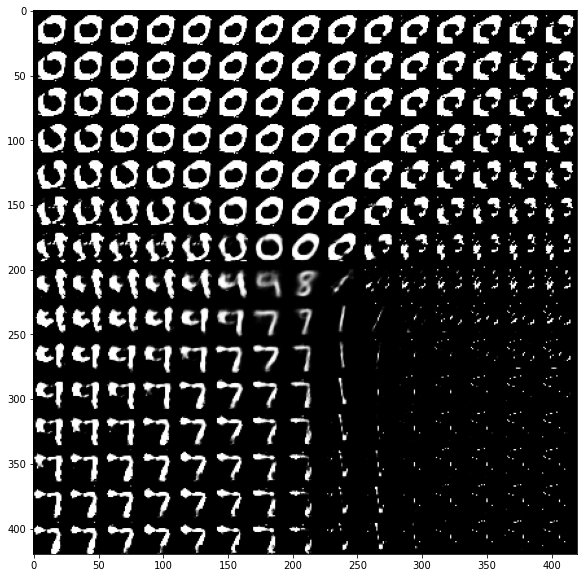

In [35]:

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
